<a href="https://colab.research.google.com/github/hhmlai/how-green-is/blob/main/How_Green_Is_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get labeled predictions of green areas of any city worldwide, and % covered from 2015 to 2020. 

## Import required modules import and copy of model from github page

In [1]:
try:
  import osmnx
  import rasterio
except:
  #install required modules if not previously installed
  !pip install -Uq --no-deps osmnx
  !pip install -Uq rasterio unidecode focal_loss geopandas rtree

import time
import requests
import tensorflow as tf
import os
from matplotlib import pyplot as plt

try:
  import sat_tools2 as st2
#download required files if not done yet
except:
  !wget https://raw.githubusercontent.com/how-green-is-my-city/how-green-is/master/notebooks/sat_tools2.py
  import sat_tools2 as st2

# set place_path as any directory inside Google Drive, to get the satelite images directly from Earth Engine, the place_path  
# These files will presist and be reused if the same area is requested again.
# Remove manualy to save space on Google Drive

place_path = '/content/drive/MyDrive/sat_predict/'

print("Login on Google Drive and Earth Engine") 
print("Required to continue with the demonstration")
st2.gdrive_ee_auth()

--2021-06-15 14:02:13--  https://raw.githubusercontent.com/how-green-is-my-city/how-green-is/master/notebooks/sat_tools2.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16232 (16K) [text/plain]
Saving to: ‘sat_tools2.py’

sat_tools2.py       100%[===================>]  15.85K  --.-KB/s    in 0s      

2021-06-15 14:02:13 (71.0 MB/s) - ‘sat_tools2.py’ saved [16232/16232]

Login on Google Drive and Earth Engine
Required to continue with the demonstration
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Download the satelite images from Earth Engine a perform the prediction using a UNet Model for any given year

Any worldwide place to search (as "Paris, France"): Paris
Got the following place: Paris, Ile-de-France, Metropolitan France, France
total area of 105.30 km2
File for year 2016 already in cache
File for year 2017 already in cache
File for year 2018 already in cache
File for year 2019 already in cache
File for year 2020 already in cache
Check progress in tasks where: https://code.earthengine.google.com/
done with images downloads
Prediction already exists, skipping...
2016: Green area predicted: 13.13%
done for 2016
Prediction already exists, skipping...
2017: Green area predicted: 12.59%
done for 2017
Prediction already exists, skipping...
2018: Green area predicted: 11.62%
done for 2018
Prediction already exists, skipping...
2019: Green area predicted: 11.85%
done for 2019
Prediction already exists, skipping...
2020: Green area predicted: 12.05%
done for 2020
done all


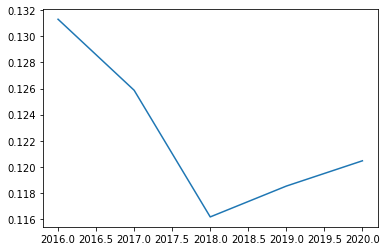

In [2]:
#Create base directory if not existent
st2.force_dirs([place_path], delete_existent=False)


#Get the city/region to perform the prediction
area_name = None
while area_name is None:
  place_name = input('Any worldwide place to search (as "Paris, France"): ')
  area_name, area_df = st2.get_area(place_name, 'EPSG:4326')

# Set the years to do the predictions
years = [2016, 2017, 2018, 2019, 2020]

#check if the area is not too large
scale = st2.check_area(area_df, 500e6)

m = None
if scale > 1:
  print('area is too large')
else:
  bounds, geometry = list(area_df.total_bounds), area_df.geometry
  green_change = []

  # Download satelite images from google Earth Engine
  images = []
  for i in years:
      year = str(i)
      image_path = st2.image_dowload(place_path, area_name, year, bounds, crs_type='EPSG:4326', force_update=False)
      if image_path:
        images.append((year, image_path, image_path[:-4] + '_pred.tif'))

  t= 0
  print("Check progress in tasks where: https://code.earthengine.google.com/")
  for _, img_path, _ in images:
      while not os.path.exists(img_path):
        print("\rWaiting for the files to be downloaded: "+str(t)+"s", end="")
        t=t+1
        time.sleep(1)
  print('done with images downloads')

  #load te model to do the predictions
  try:
    model = tf.keras.models.load_model('unet.h5')
  except:
    !wget https://raw.githubusercontent.com/how-green-is-my-city/how-green-is/master/notebooks/unet.h5
    model = tf.keras.models.load_model('unet.h5')

  for year, img_path, pred_path in images:
      green_pred = st2.predict_with_tile(input_file=img_path, output_file=pred_path, model=model, force_update=False)
      print(year + ': Green area predicted: {:.2%}'.format(green_pred))
      st2.crop_area(pred_path, geometry)
      green_change.append(green_pred)
      print('done for ' + year)
  print('done all')
  plt.plot(years,green_change)

# Visualize the base satellite image and green area predictions. Possible to hide/unhide green area predictions for each year

In [3]:
# Set the years to be visible by default in folium (from 2016 to 2020) 
show_years = [2016, 2020]

m = st2.folium_preview(img_path, images, show_years, area_df.geometry) 
m

loading prediction image for year 2016
loading prediction image for year 2020


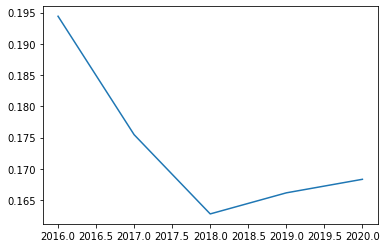